In diesem Notebook werden auf verschiedenen Modalitäten verschiedene Modelle trainiert, angewendet und ausgewertet. Jeweils: Random Forest, XGBoost, Logistic Regression, SVM, Neuronales Netz

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score

# Vorbereitung: Data Split in 3 Datasets!

Preprocessing der Kategorsischen Variablen..

In [ ]:
df = pd.read_csv("features_enriched_tab_img_text.csv")
print(df.shape)
print(df.columns)

df = df.rename(
    columns={
        "stars": "tab_star",
        "year": "tab_year",
        "month": "tab_month",
        "day": "tab_day",
        "likesCount": "tab_likesCount",
        "reviewerNumberOfReviews": "tab_reviewerNumberOfReviews",
        "isLocalGuide": "tab_isLocalGuide",
        "dayofweek": "tab_dayofweek",
        "elapsed_days": "tab_elapsed_days",
        "when_on_day_4hbin": "tab_when_on_day_4hbin",
    }
)

df["label"] = df["label"].replace({"real": 0, "fake": 1})
df["text_sentiment"] = df["text_sentiment"].replace(
    {"negative": 0, "neutral": 1, "positive": 2}
)

df_num = df.select_dtypes(include=["float64", "int64"])
df_cat = df.select_dtypes(include=["object"])

df.to_csv("features_enriched_tab_img_text_preproc.csv", index=False)

In [ ]:
df = pd.read_csv("features_enriched_tab_img_text_preproc.csv")

print(df.shape)
print(df.columns)
print(df.filter(regex='text_'))

Train-Validation-Test-Split.

In [45]:
df = pd.read_csv('features_enriched_tab_img_text_preproc.csv')
print(f"Orginal:\t{df.shape}")
print("---------------------------------------------------------------------------------------------")

train, test = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=1)
train_val, test = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=1)
train, val = train_test_split(train_val, test_size=0.2, stratify=train_val['label'], random_state=1)
print(f"Train:\t\t{train.shape}")
print(f"Validation:\t{val.shape}")
print(f"Test:\t\t{test.shape}")

train.to_csv('detection_train.csv', index=False)
val.to_csv('detection_val.csv', index=False)
test.to_csv('detection_test.csv', index=False)
train_val.to_csv('detection_train_val.csv', index=False)

Orginal:	(1408, 574)
---------------------------------------------------------------------------------------------
Train:		(900, 574)
Validation:	(226, 574)
Test:		(282, 574)


## Baseline mit Dummy-Klassifikator: Coinflip

In [19]:
from sklearn.dummy import DummyClassifier

train_df = pd.read_csv("detection_train.csv")
val_df = pd.read_csv("detection_val.csv")
test_df = pd.read_csv("detection_test.csv")

used_features_variation = []
used_features_img0 = train_df.filter(regex="^(feature)").columns
used_features_img2 = train_df.filter(regex="^(img_feature)").columns
used_features_tab = train_df.filter(regex="^(tab_)").columns
used_features_text = train_df.filter(regex="^(text_)").columns


for used_features in used_features_variation:
    # get the name of used_feature columns names until first "_"
    print(f"______Classification for______-")
    X_train, y_train = train_df[used_features], train_df["label"]
    X_val, y_val = val_df[used_features], val_df["label"]
    X_test, y_test = test_df[used_features], test_df["label"]

    dummy = DummyClassifier(strategy="uniform", random_state=1)
    dummy.fit(X_train, y_train)
    y_pred_val = dummy.predict(X_val)
    y_pred_test = dummy.predict(X_test)

    print(
        f"____________________________EVALUATION_DUMMY_CLASSIFICATOR_BASELINE_________________________________________________"
    )
    accuracy_val = accuracy_score(y_val, y_pred_val)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    confusion = confusion_matrix(y_test, y_pred_test)
    auc = roc_auc_score(y_test, y_pred_test)
    print(f"Validation set accuracy: {accuracy_val}")
    print(f"Test set accuracy: {accuracy_test}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 score: {f1}")
    print(f"AUC: {auc}")
    print(f"Confusion matrix:\n{confusion}")


def apply_and_eval_dummy_classificator_on_test(used_features):
    X_train, y_train = train_df[used_features], train_df["label"]
    X_val, y_val = val_df[used_features], val_df["label"]
    X_test, y_test = test_df[used_features], test_df["label"]

    dummy = DummyClassifier(strategy="uniform", random_state=1)
    dummy.fit(X_train, y_train)
    y_pred_val = dummy.predict(X_val)
    y_pred_test = dummy.predict(X_test)
    accuracy_val = accuracy_score(y_val, y_pred_val)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    confusion = confusion_matrix(y_test, y_pred_test)
    auc = roc_auc_score(y_test, y_pred_test)

    accuracy_val = "{:.4f}".format(accuracy_val)
    accuracy_test = "{:.4f}".format(accuracy_test)
    f1 = "{:.4f}".format(f1)
    precision = "{:.4f}".format(precision)
    recall = "{:.4f}".format(recall)
    auc = "{:.4f}".format(auc)

    return accuracy_val, accuracy_test, f1, precision, recall, confusion, auc


def apply_and_eval_dummy_on_val (used_features):
    X_train, y_train = train_df[used_features], train_df["label"]
    X_val, y_val = val_df[used_features], val_df["label"]
    X_test, y_test = test_df[used_features], test_df["label"]

    dummy = DummyClassifier(strategy="uniform", random_state=1)
    dummy.fit(X_train, y_train)
    y_pred_val = dummy.predict(X_val)

    accuracy_val = accuracy_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val)
    precision = precision_score(y_val, y_pred_val)
    recall = recall_score(y_val, y_pred_val)
    confusion = confusion_matrix(y_val, y_pred_val)
    auc = roc_auc_score(y_val, y_pred_val)
    
    accuracy_val = "{:.4f}".format(accuracy_val)
    accuracy_test = "{:.4f}".format(accuracy_test)
    f1 = "{:.4f}".format(f1)
    precision = "{:.4f}".format(precision)
    recall = "{:.4f}".format(recall)
    auc = "{:.4f}".format(auc)
    return accuracy_val, f1, precision, recall, confusion, auc


used_features_img0 = train_df.filter(regex="^(feature)").columns
used_features_img2 = train_df.filter(regex="^(img_feature)").columns
used_features_tab = train_df.filter(regex="^(tab_)").columns
used_features_text = train_df.filter(regex="^(text_)").columns


print(f"____________________________EVALUATION_DUMMY_CLASSIFICATOR: Image Features_________________________________________________")
accuracy_val, accuracy_test, f1, precision, recall, confusion, auc = apply_and_eval_dummy_classificator_on_test(used_features_img0)
print(f"acc_val:\t{accuracy_val}\nacc_test:\t{accuracy_test}\nPrecision:\t{precision}\nRecall:\t\t{recall}\nAUC:\t\t{auc}\nConfusion matrix:\n{confusion}")


print(f"____________________________EVALUATION_DUMMY_CLASSIFICATOR: Image (Url/2) Features_________________________________________________")
apply_and_eval_dummy_classificator_on_test(used_features_img2)
print(f"acc_val:\t{accuracy_val}\nacc_test:\t{accuracy_test}\nPrecision:\t{precision}\nRecall:\t\t{recall}\nAUC:\t\t{auc}\nConfusion matrix:\n{confusion}")


print(f"____________________________EVALUATION_DUMMY_CLASSIFICATOR: tab Features_________________________________________________")
apply_and_eval_dummy_classificator_on_test(used_features_tab)
print(f"acc_val:\t{accuracy_val}\nacc_test:\t{accuracy_test}\nPrecision:\t{precision}\nRecall:\t\t{recall}\nAUC:\t\t{auc}\nConfusion matrix:\n{confusion}")


print(f"____________________________EVALUATION_DUMMY_CLASSIFICATOR: text Features_________________________________________________")
apply_and_eval_dummy_classificator_on_test(used_features_text)
print(f"acc_val:\t{accuracy_val}\nacc_test:\t{accuracy_test}\nPrecision:\t{precision}\nRecall:\t\t{recall}\nAUC:\t\t{auc}\nConfusion matrix:\n{confusion}")



____________________________EVALUATION_DUMMY_CLASSIFICATOR: Image Features_________________________________________________
acc_val:	0.4646
acc_test:	0.4965
Precision:	0.4966
Recall:		0.5177
AUC:		0.4965
Confusion matrix:
[[67 74]
 [68 73]]
____________________________EVALUATION_DUMMY_CLASSIFICATOR: Image (Url/2) Features_________________________________________________
acc_val:	0.4646
acc_test:	0.4965
Precision:	0.4966
Recall:		0.5177
AUC:		0.4965
Confusion matrix:
[[67 74]
 [68 73]]
____________________________EVALUATION_DUMMY_CLASSIFICATOR: tab Features_________________________________________________
acc_val:	0.4646
acc_test:	0.4965
Precision:	0.4966
Recall:		0.5177
AUC:		0.4965
Confusion matrix:
[[67 74]
 [68 73]]
____________________________EVALUATION_DUMMY_CLASSIFICATOR: text Features_________________________________________________
acc_val:	0.4646
acc_test:	0.4965
Precision:	0.4966
Recall:		0.5177
AUC:		0.4965
Confusion matrix:
[[67 74]
 [68 73]]


# TAB

XGBoost

Validation set accuracy: 0.9247787610619469
Test set accuracy: 0.9042553191489362
F1 score: 0.9251101321585904
Precision: 0.8958333333333334
Recall: 0.9148936170212766
Confusion matrix:
[[126  15]
 [ 12 129]]
AUC: 0.9042553191489361
________________________________________________________________________


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


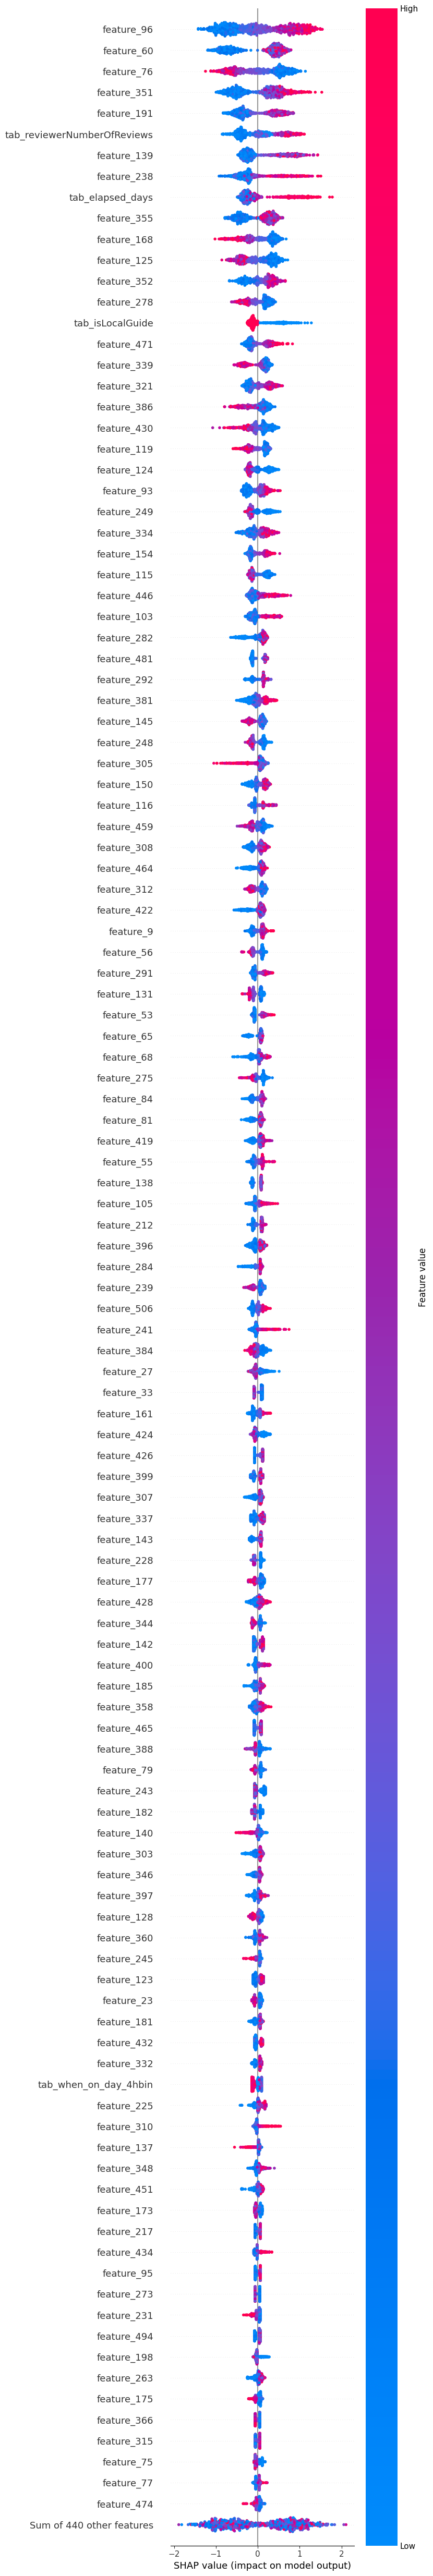

In [24]:
from xgboost import XGBClassifier
import shap

train_df = pd.read_csv('detection_train.csv')
val_df = pd.read_csv('detection_val.csv')
test_df = pd.read_csv('detection_test.csv')

used_features = train_df.filter(regex='^(feature_|text_|tab_)').columns

X_train, y_train = train_df[used_features], train_df['label']
X_val, y_val = val_df[used_features], val_df['label']
X_test, y_test = test_df[used_features], test_df['label']

# Perform normalization
X_train_norm = (X_train - X_train.mean()) / X_train.std()
X_val_norm = (X_val - X_train.mean()) / X_train.std()
X_test_norm = (X_test - X_train.mean()) / X_train.std()


xgb = XGBClassifier(random_state=3, n_estimators=1000)
xgb.fit(X_train_norm, y_train)
y_pred_val = xgb.predict(X_val_norm)
y_pred_test = xgb.predict(X_test_norm)

accuracy_val = accuracy_score(y_val, y_pred_val)
accuracy_test = accuracy_score(y_test, y_pred_test)
f1 = f1_score(y_val, y_pred_val)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
confusion = confusion_matrix(y_test, y_pred_test)
auc = roc_auc_score(y_test, y_pred_test)
print(f"Validation set accuracy: {accuracy_val}")
print(f"Test set accuracy: {accuracy_test}")
print(f"F1 score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Confusion matrix:\n{confusion}")
print(f"AUC: {auc}")
print(f"________________________________________________________________________")

explainer = shap.Explainer(xgb, X_train_norm, feature_names=X_train.columns)
shap_values = explainer(X_train_norm)

shap.plots.beeswarm(shap_values, max_display=120,show=False) 
plt.tight_layout()

plt.savefig('shap_text_img_xgb.svg', format='svg', dpi=1200)

# Tabular

# Image

# Multimodal